In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
plt.style.use('Solarize_Light2') 
from pylab import rcParams  

import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import cufflinks

## 1)PREDICTING USD/TL CURRENCY

A)Data Cleaning

In [4]:

currency=pd.read_csv("./data/USD_TRY Geçmiş Verileri.csv")
currency1=pd.DataFrame()
currency1=['Kur','Currency']
currency1=pd.DataFrame(currency1).T
i=2
j=0
while j<220:

  currency1[i]=currency["Şimdi"][j]
  i=i+1
  j=j+1
currency1=currency1.T
currency1=currency1.applymap(lambda x: str(x.replace(',','.')))
currency2=pd.DataFrame(currency['Şimdi'])
kur=currency2.applymap(lambda x: str(x.replace(',','.')))
kur=kur.astype(float)
kur




,Şimdi
0,1.3410
1,1.3270
2,1.3135
3,1.4206
4,1.4895
...,...
222,17.9114
223,18.1868
224,18.5000
225,18.5920


In [5]:
dates= pd.date_range('2004-01-01','2022-12-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()
df["TIME"]=dates
df["Value"]=kur.values

# B)Data Processing

In [6]:
df['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df['TIME'] =  pd.to_datetime(df['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df = df.set_index(['TIME'])

Text(0.5, 1.0, 'USD/TL')

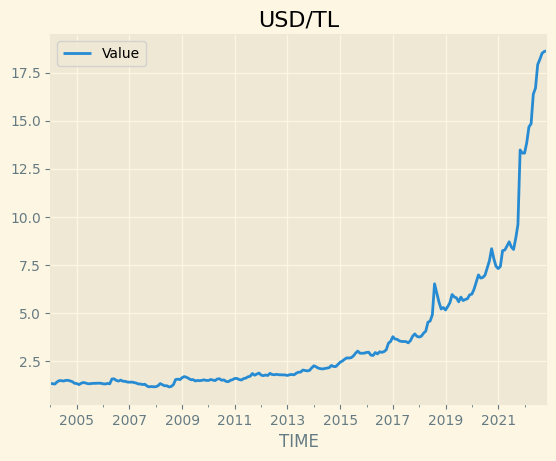

In [7]:
df.plot()
plt.title("USD/TL")

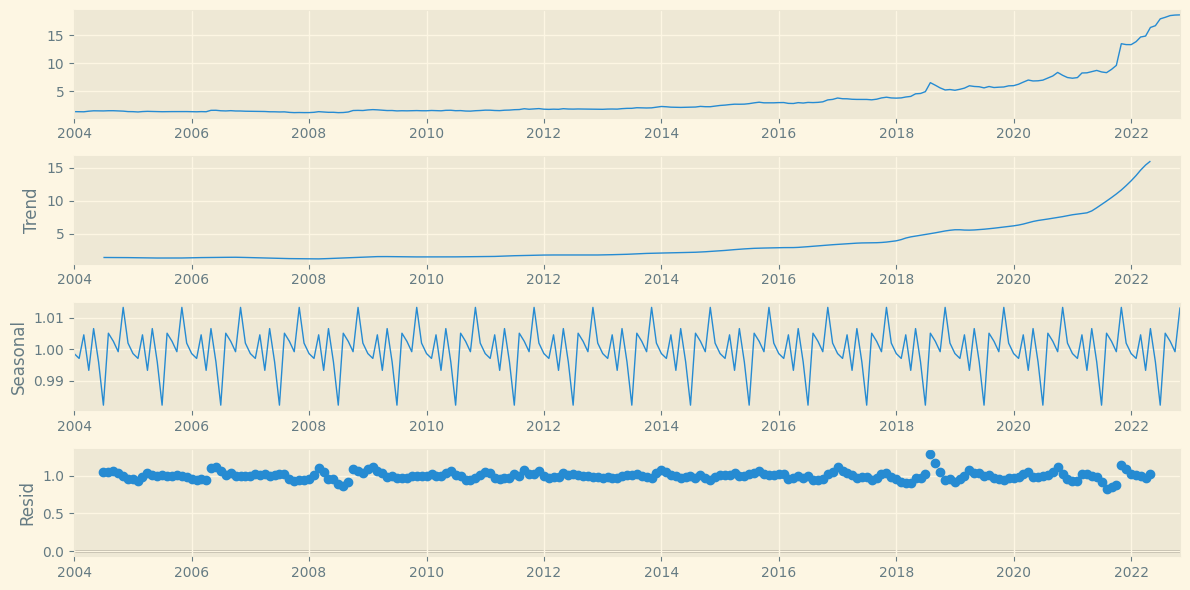

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')


rcParams['figure.figsize'] = 12, 6
plt.rc('lines', linewidth=1, color='y')

fig = result.plot()
#print(plt.style.available)


# C)PREDICTION MODEL

In [10]:
from pmdarima.arima import auto_arima

results = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=300.176, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=208.800, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=191.084, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=297.382, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=191.313, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=191.318, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=209.042, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=191.382, Time=1.82 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=193.044, Time=0.21 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=189.069, Time=0.36 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=297.410, Time=0.07 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=189.120, Time=0.52 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=189.073, Time=0.81 sec
 ARIMA(0,1,2)(1,1,0)[12]             

In [11]:
results.aic()

189.0689199415544

In [12]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df.astype(float),
                                order=(0,1,2),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()


c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [13]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [17]:
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail()

,lower Value,upper Value,Predicted,Observed,"Diff, %%"
2022-07-01,16.171863,17.614602,16.893233,17.9114,-5.684465
2022-08-01,17.552817,18.995555,18.274186,18.1868,0.480492
2022-09-01,17.676260,19.118999,18.397630,18.5000,-0.553353
2022-10-01,17.922743,19.365481,18.644112,18.5920,0.280292
2022-11-01,18.324863,19.767602,19.046232,18.6217,2.279772


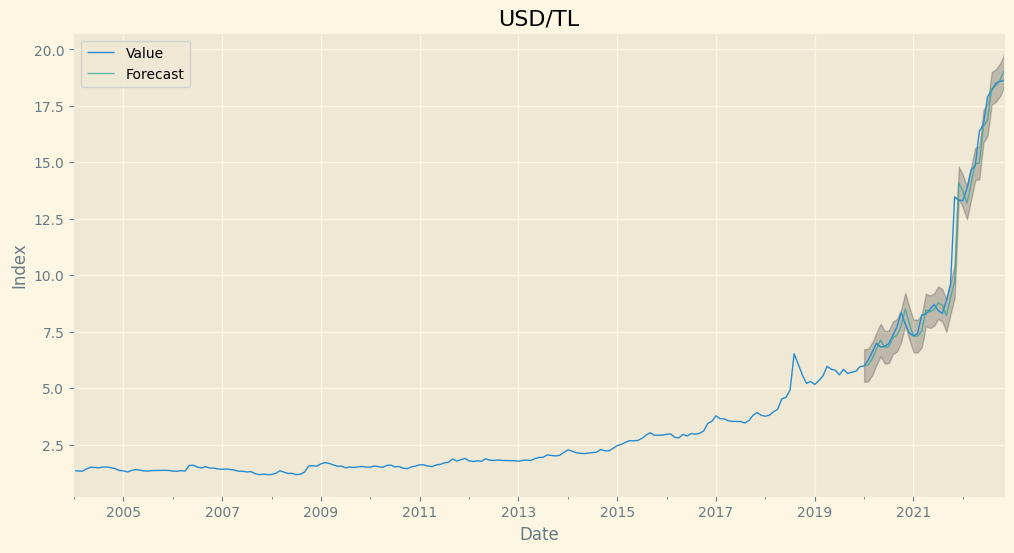

In [18]:
ax = df['2004':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Index')
plt.title("USD/TL")
plt.legend()
rcParams['figure.figsize'] = 12, 5
plt.show()

In [35]:
# Get forecast 3 years ahead in future
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

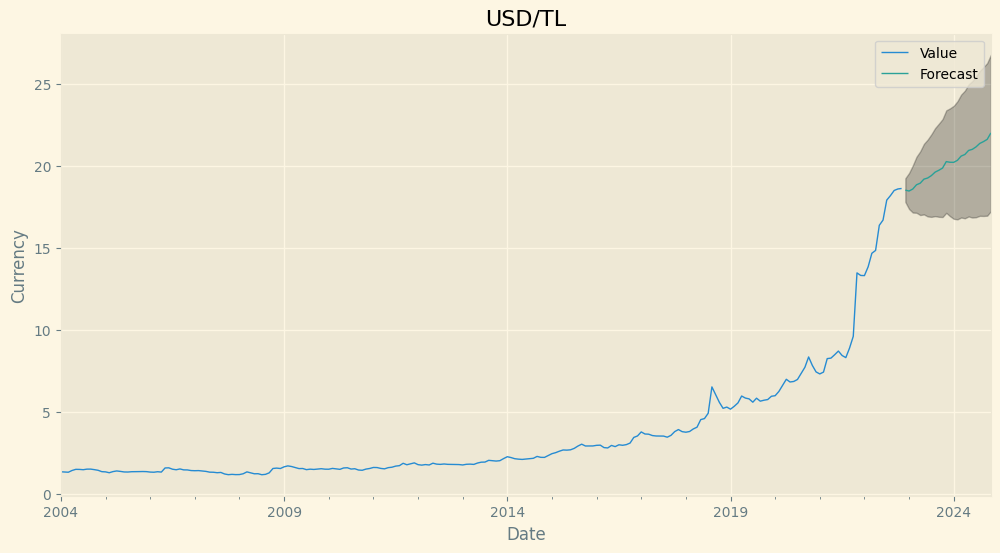

In [36]:
ax = df.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Currency')
plt.title("USD/TL")

plt.legend()

plt.show()

In [37]:
pred_ci

,lower Value,upper Value
2022-12-01,17.799849,19.242588
2023-01-01,17.369256,19.563355
2023-02-01,17.152686,20.023644
2023-03-01,17.139024,20.555261
2023-04-01,17.001349,20.886899
2023-05-01,17.039202,21.343190
2023-06-01,16.915964,21.601168
2023-07-01,16.888683,21.926336
2023-08-01,16.934620,22.301628
2023-09-01,16.892205,22.569492


Text(0.5, 1.0, 'USD/TL')

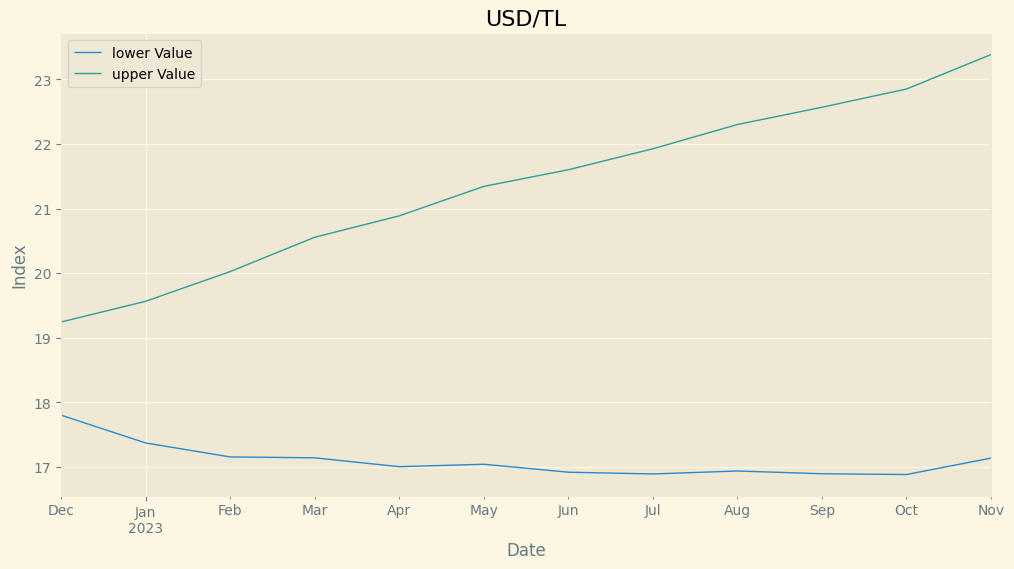

In [38]:
rcParams['figure.figsize'] = 12, 6
pred_ci.head(12).plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.title("USD/TL")

In [39]:
pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Mean'].head(10)

2022-12-01    18.521218
2023-01-01    18.466305
2023-02-01    18.588165
2023-03-01    18.847142
2023-04-01    18.944124
2023-05-01    19.191196
2023-06-01    19.258566
2023-07-01    19.407509
2023-08-01    19.618124
2023-09-01    19.730848
Freq: MS, Name: Mean, dtype: float64

Text(0.5, 1.0, 'USD/TL Prediction for next 24 months')

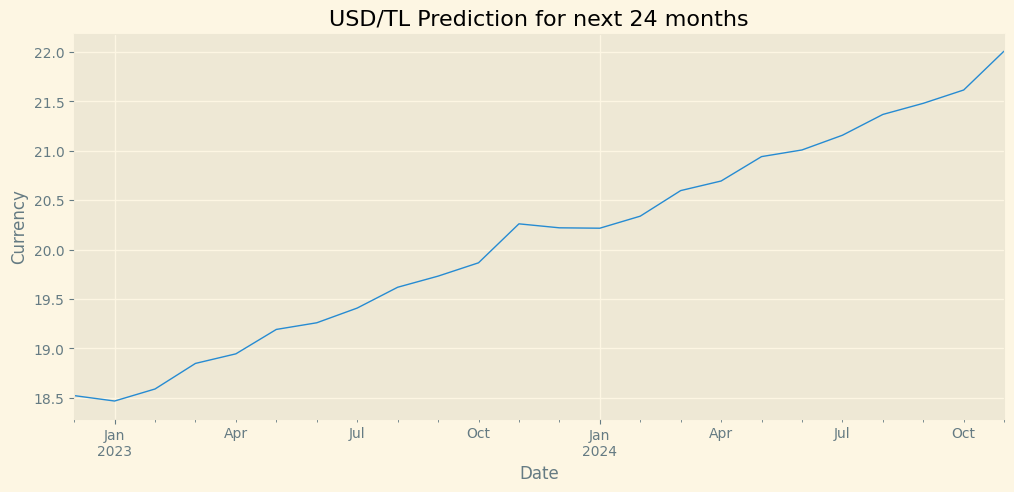

In [41]:
rcParams['figure.figsize'] = 12,5
pred_ci["Mean"].plot()
plt.xlabel('Date')
plt.ylabel('Currency')
plt.title("USD/TL Prediction for next 24 months")